In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/zhu-2019/Adult_Cerebrail_Cortex/Adult_CTX_RNA/'
SCATAC_DIR = '../data/zhu-2019/Adult_Cerebrail_Cortex/Adult_CTX_DNA/'
META_PATH = '../data/zhu-2019/Adult_Cerebrail_Cortex/Cell_embeddings.xls'

# MetaData

In [4]:
metadata = pd.read_csv(META_PATH, sep='\t', index_col='ID')
metadata.head()

Rep  Cluster  Combined_Dim1  Combined_Dim2  DNA_Dim1  DNA_Dim2  \
ID                                                                            
01:30:88:16    2        9       4.339384      -2.821956  0.634181  1.751429   
02:03:35:21    1        9       2.213908      -3.100846 -1.940852  1.123837   
02:03:45:33    1        3       1.209223       5.200210 -2.626761 -4.325078   
02:03:73:23    1        9       3.491545      -5.545420 -3.059138  2.021004   
02:04:46:38    2        6       0.818626       0.446194 -0.741627 -1.245768   

             RNA_Dim1  RNA_Dim2  
ID                               
01:30:88:16 -2.506224  1.900988  
02:03:35:21  0.245147 -1.293293  
02:03:45:33  3.580096  1.701881  
02:03:73:23 -2.798065  2.377513  
02:04:46:38  0.677586  0.327638

# scRNA-seq Data

In [5]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_symbols', cache=True)
scrna.obs = metadata
scrna

CPU times: user 356 ms, sys: 60 ms, total: 416 ms
Wall time: 692 ms


AnnData object with n_obs × n_vars = 15191 × 29624
    obs: 'Rep', 'Cluster', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'

In [6]:
scrna.var.head()

gene_ids
Gnai3  ENSMUSG00000000001
Pbsn   ENSMUSG00000000003
Cdc45  ENSMUSG00000000028
H19    ENSMUSG00000000031
Scml2  ENSMUSG00000000037

## Data Cleaning

In [7]:
cell_types_map = {
    1: "AS",
    2: "MG",
    3: "OC",
    4: "Ex1",
    5: "Ex2",
    6: "Ex3",
    7: "In1",
    8: "In2",
    9: "In3"
}

In [8]:
scrna.obs = scrna.obs.rename(columns={'Cluster': 'cell_type'})

In [9]:
scrna.obs['cell_type'] = scrna.obs['cell_type'].apply(lambda x: cell_types_map[x])

In [10]:
scrna.obs['Rep'] = scrna.obs['Rep'].astype('category')
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [11]:
scrna.obsm['X_umap'] = scrna.obs[['RNA_Dim1', 'RNA_Dim2']].to_numpy()

In [12]:
scrna

AnnData object with n_obs × n_vars = 15191 × 29624
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

# Quality Control

In [13]:
scrna.var_names_make_unique()

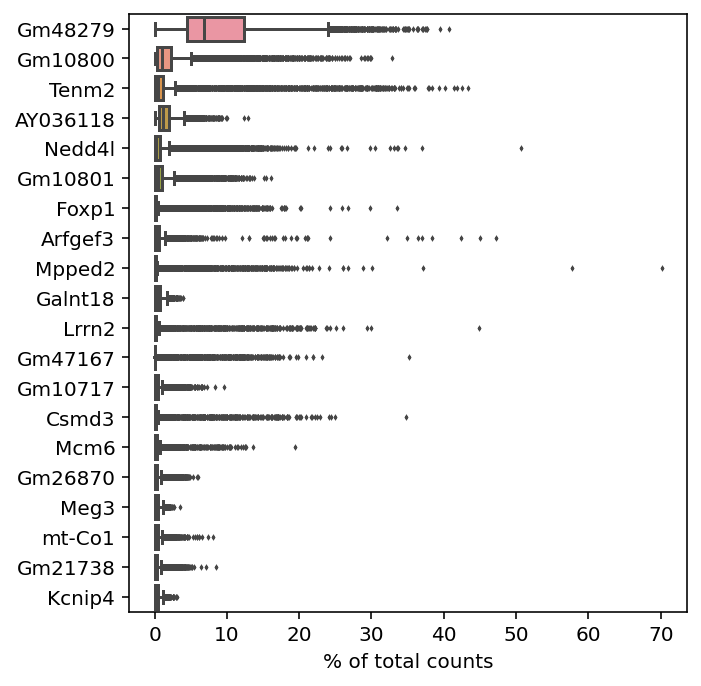

In [14]:
sc.pl.highest_expr_genes(scrna, n_top=20)

In [15]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 15163 × 27864
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'n_genes'
    var: 'gene_ids', 'n_cells'
    obsm: 'X_umap'

## Qalculate QC metrics including Mitochondrial genes

In [16]:
scrna.var['mt'] = scrna.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 15163 × 27864
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_umap'

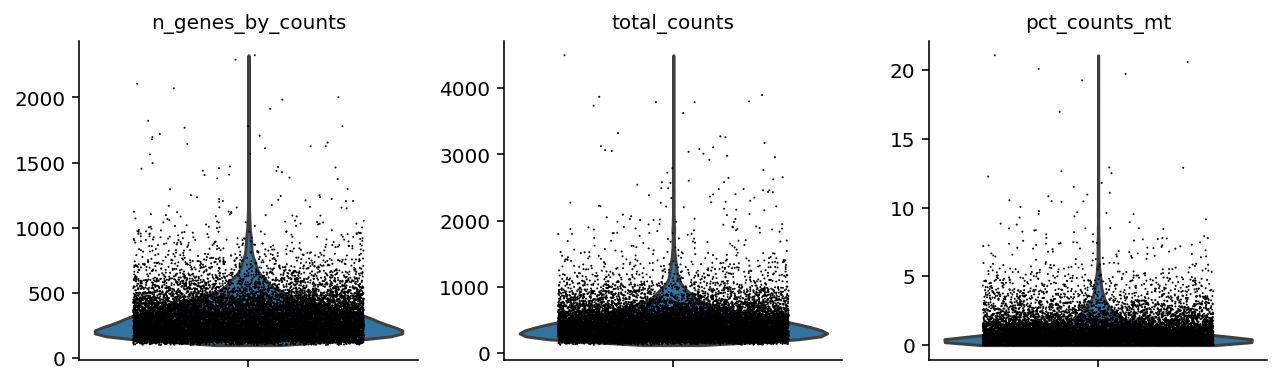

In [17]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

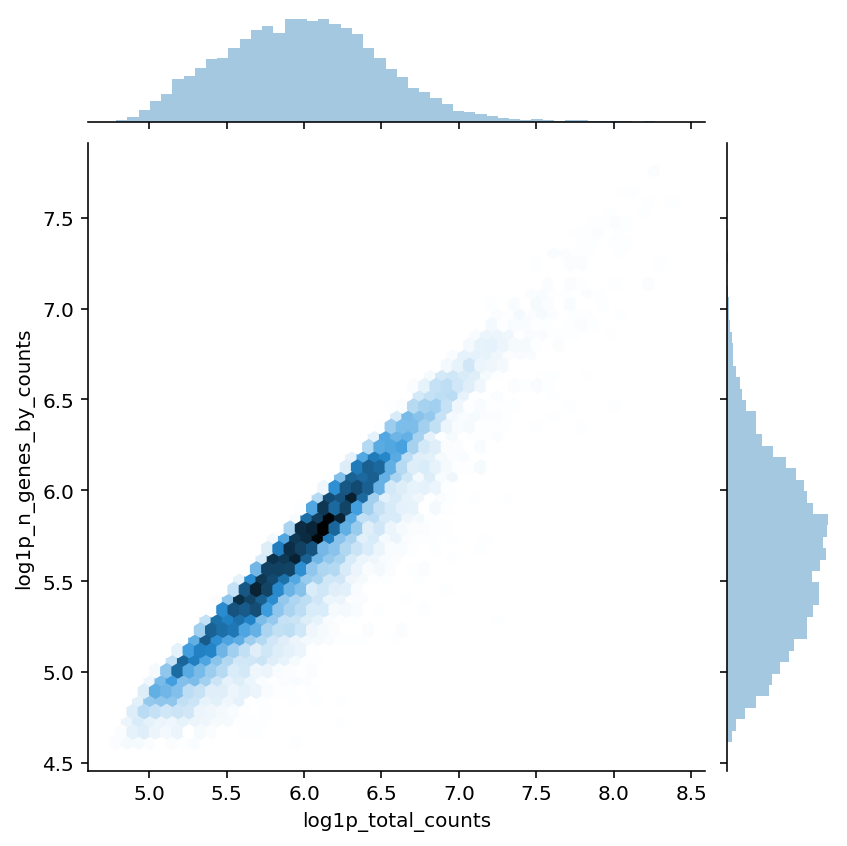

In [18]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex');

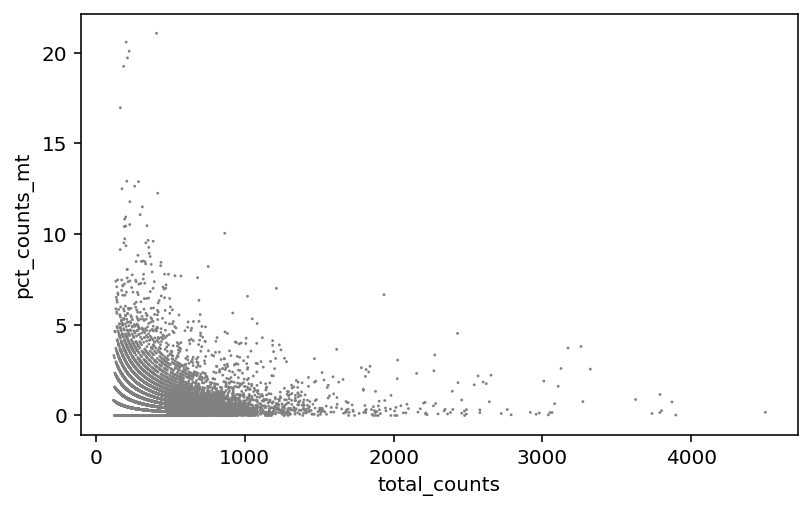

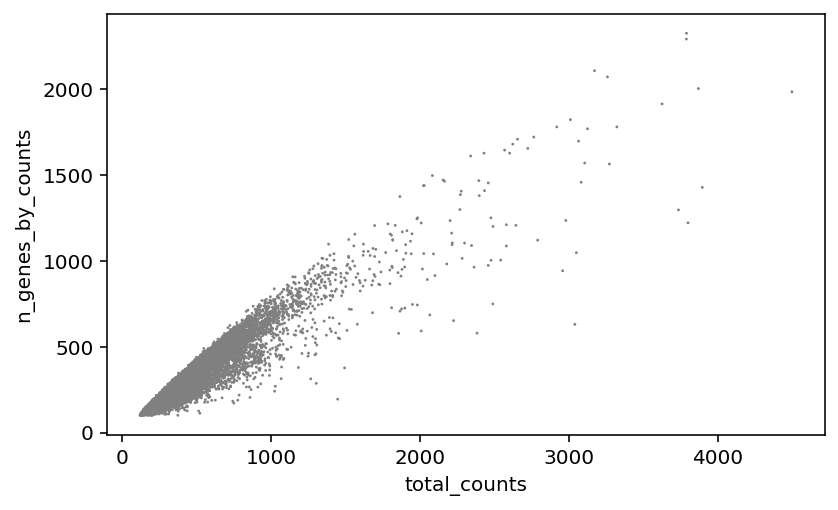

In [19]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out high mitochondrial samples and samples with highest number of genes:

In [20]:
scrna = scrna[scrna.obs.n_genes_by_counts < 1500, :]
scrna = scrna[scrna.obs.pct_counts_mt < 5, :]
scrna

View of AnnData object with n_obs × n_vars = 14952 × 27864
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_umap'

## Normalization

In [21]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

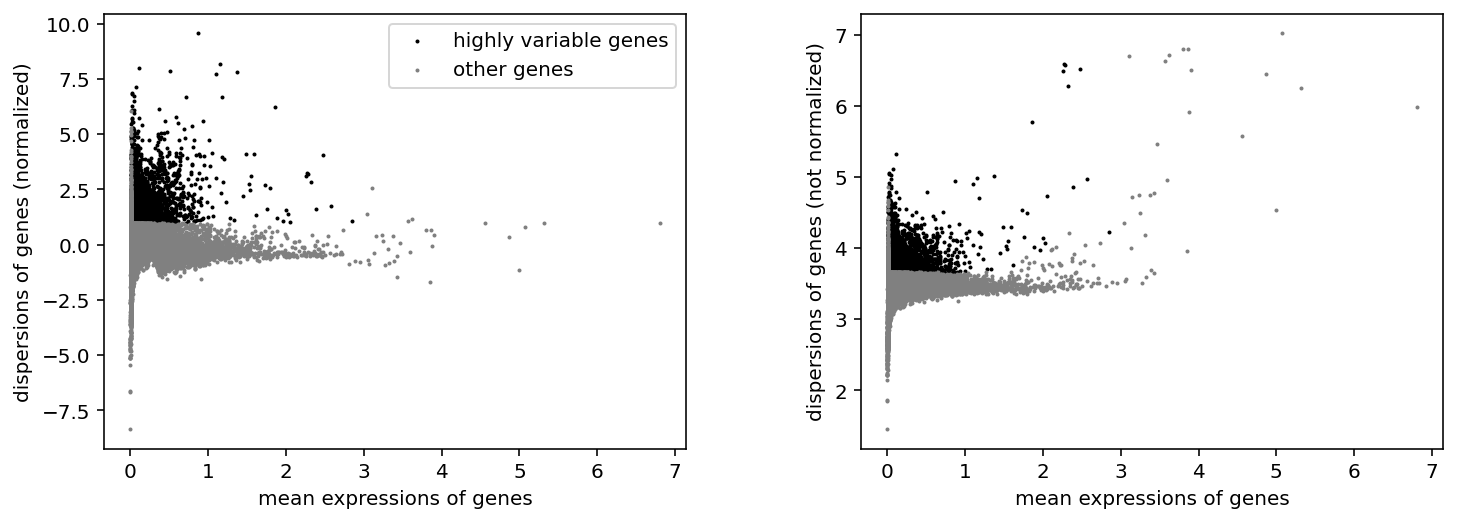

In [22]:
sc.pp.highly_variable_genes(scrna, min_mean=0.0125, max_mean=3, min_disp=1)
sc.pl.highly_variable_genes(scrna)

In [23]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 14952 × 2693
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 'X_umap'

## Visualization

### UMAP using coordinates provided by the authors

Trying to set attribute `.uns` of view, copying.


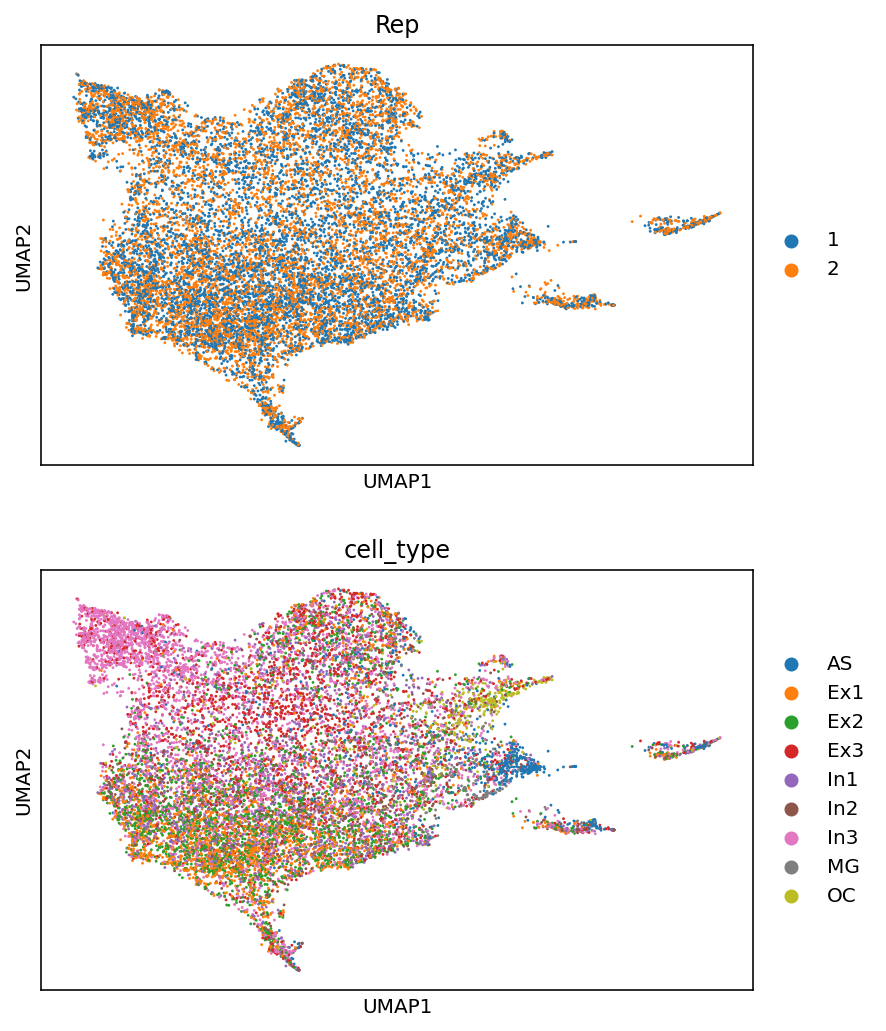

In [24]:
sc.pl.umap(scrna, color=['Rep', 'cell_type'], ncols=1)

### Running UMAP

In [41]:
sc.pp.neighbors(scrna, random_state=42)
sc.tl.umap(scrna, random_state=42)

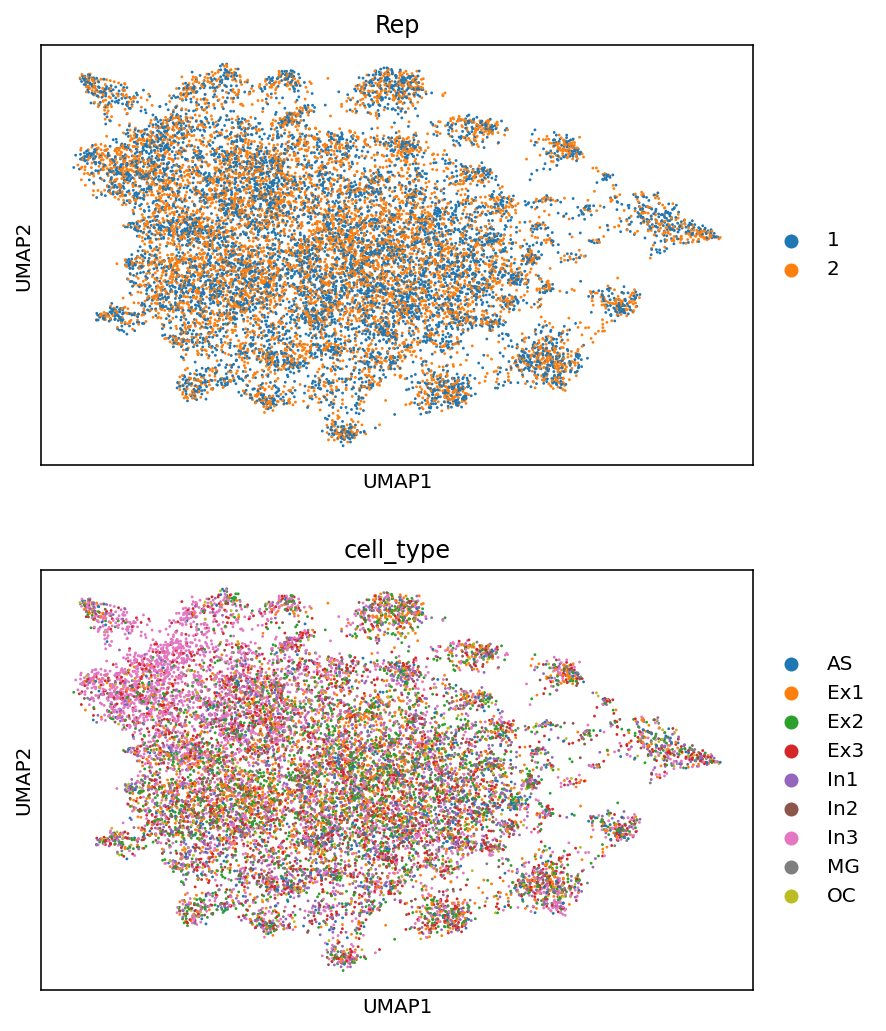

In [42]:
sc.pl.umap(scrna, color=['Rep', 'cell_type'], ncols=1)

---
# scATAC-seq Data

In [43]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)
scatac.obs = metadata
scatac

CPU times: user 9.29 s, sys: 860 ms, total: 10.1 s
Wall time: 12.7 s


AnnData object with n_obs × n_vars = 15191 × 2614863
    obs: 'Rep', 'Cluster', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'

In [44]:
scatac.var.head()

gene_ids
chr10:10000000-10001000      chr10:10000000-10001000
chr10:100000000-100001000  chr10:100000000-100001000
chr10:100002000-100003000  chr10:100002000-100003000
chr10:100003000-100004000  chr10:100003000-100004000
chr10:100004000-100005000  chr10:100004000-100005000

## Data Cleaning

In [46]:
scatac.obs = scatac.obs.rename(columns={'Cluster': 'cell_type'})

In [47]:
scatac.obs['cell_type'] = scatac.obs['cell_type'].apply(lambda x: cell_types_map[x])

In [48]:
scatac.obs['Rep'] = scatac.obs['Rep'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

In [49]:
scatac.obsm['X_umap'] = scatac.obs[['DNA_Dim1', 'DNA_Dim2']].to_numpy()

In [50]:
scatac

AnnData object with n_obs × n_vars = 15191 × 2614863
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

## Binarization

In [51]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

CPU times: user 3.18 s, sys: 260 ms, total: 3.44 s
Wall time: 3.44 s


AnnData object with n_obs × n_vars = 15191 × 2614863
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

## Quality Control

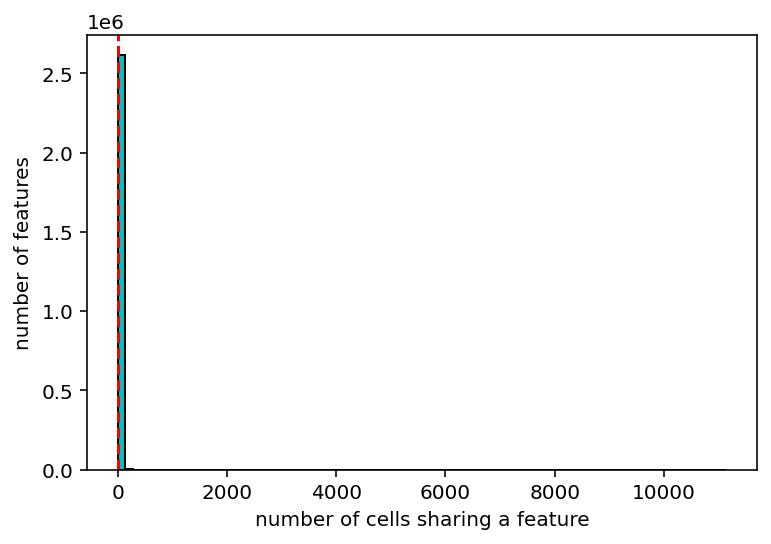

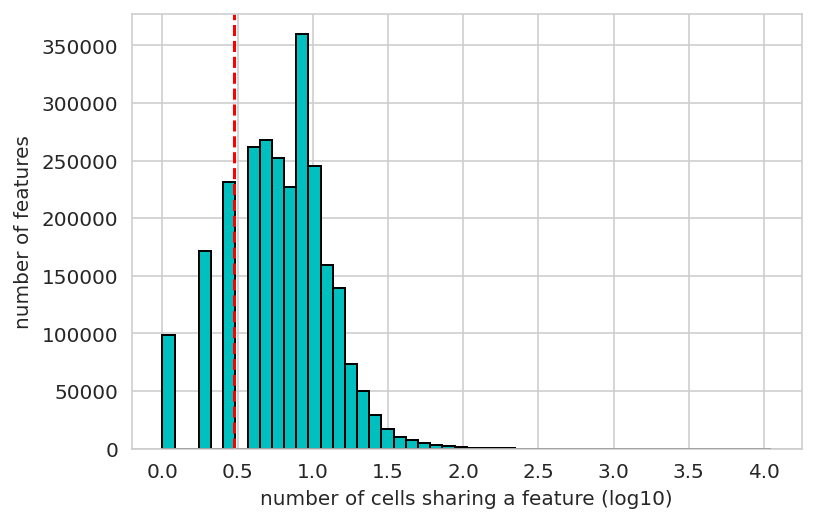

In [52]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=3)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=3)

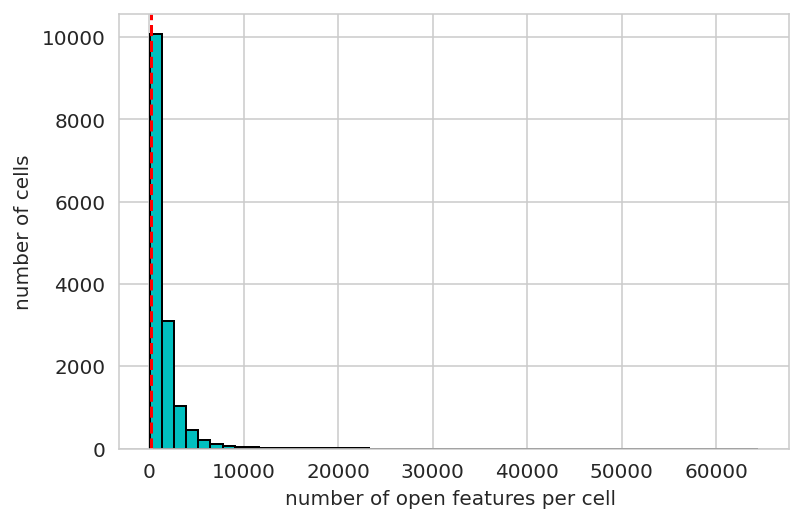

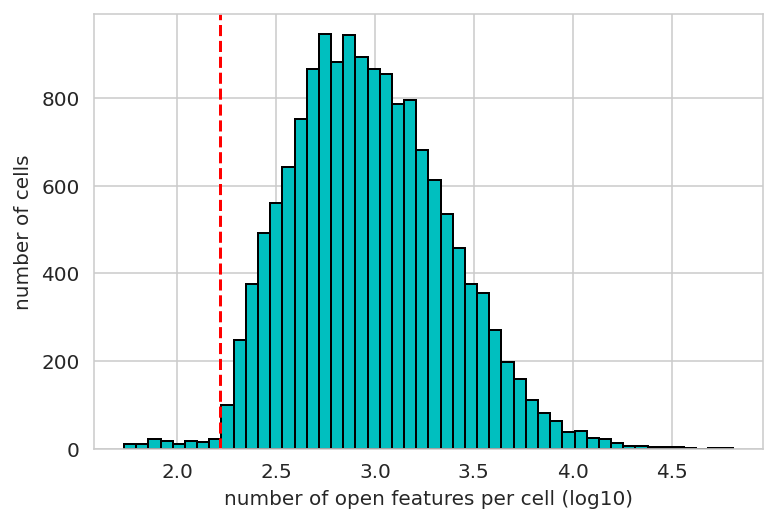

In [53]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=165)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=165)

## Filter low quality cells and peaks

In [54]:
epi.pp.filter_cells(scatac, min_features=165)
epi.pp.filter_features(scatac, min_cells=3)
scatac

AnnData object with n_obs × n_vars = 15071 × 2344311
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells'
    obsm: 'X_umap'

In [55]:
scatac.obs['nb_features'].describe()

count    15071.000000
mean      1486.262955
std       2041.771778
min        167.000000
25%        499.500000
50%        894.000000
75%       1725.000000
max      64438.000000
Name: nb_features, dtype: float64

In [56]:
scatac.var['commonness'].describe()

count    2.344311e+06
mean     9.371117e+00
std      3.649082e+01
min      3.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      1.114100e+04
Name: commonness, dtype: float64

In [57]:
scatac.var['commonness'].median()

7.0

In [58]:
scatac = scatac[:, scatac.var['commonness'] > 7]
scatac

View of AnnData object with n_obs × n_vars = 15071 × 1104393
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells'
    obsm: 'X_umap'

## Selecting variable peaks

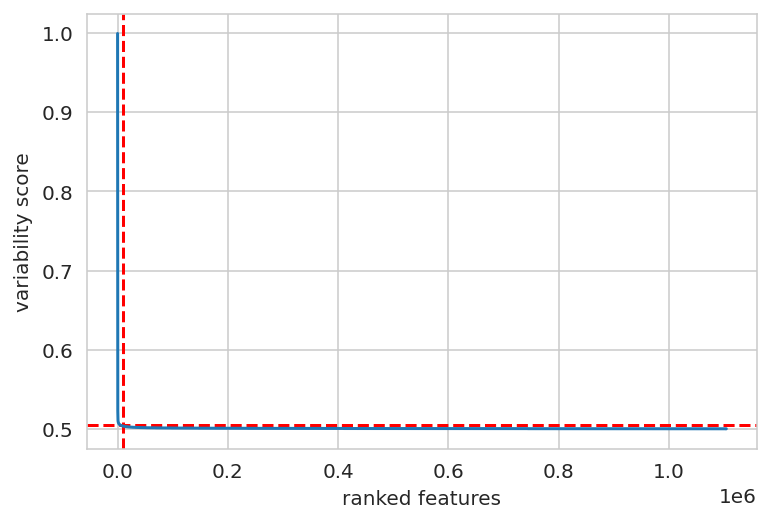

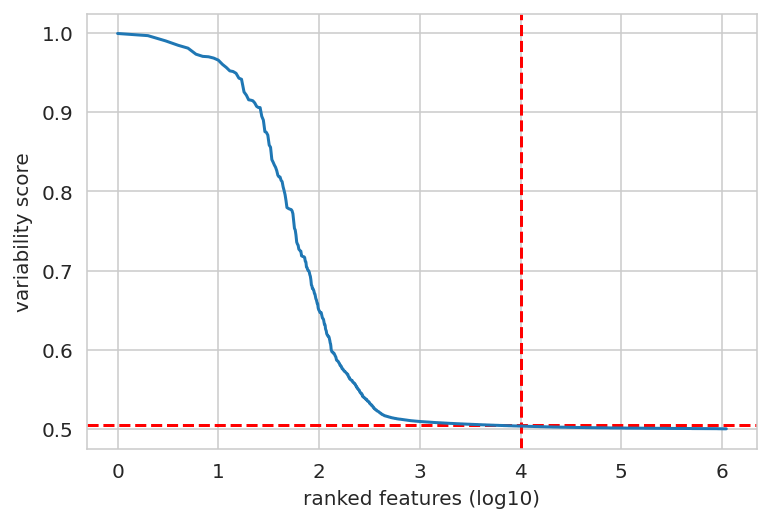

In [60]:
min_score_value = 0.505
nb_feature_selected = 10000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

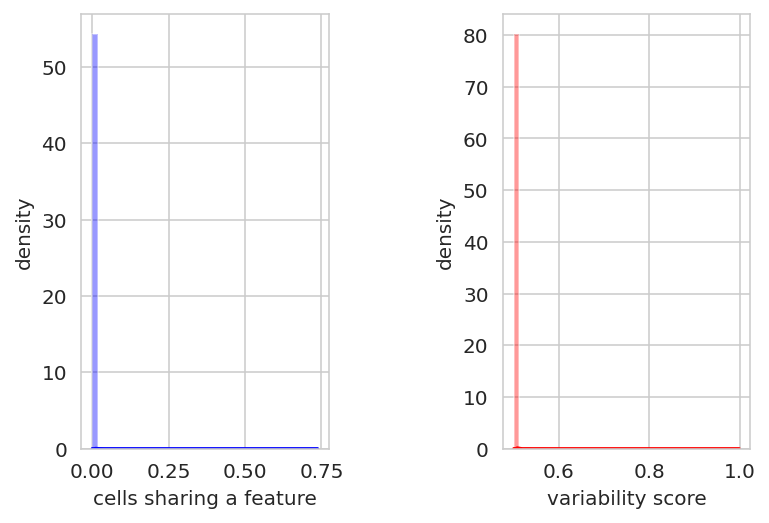

CPU times: user 3.3 s, sys: 352 ms, total: 3.66 s
Wall time: 3.64 s


In [61]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

In [62]:
scatac

View of AnnData object with n_obs × n_vars = 15071 × 10155
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

## Visualization

### UMAP using coordinates provided by the authors

Trying to set attribute `.uns` of view, copying.


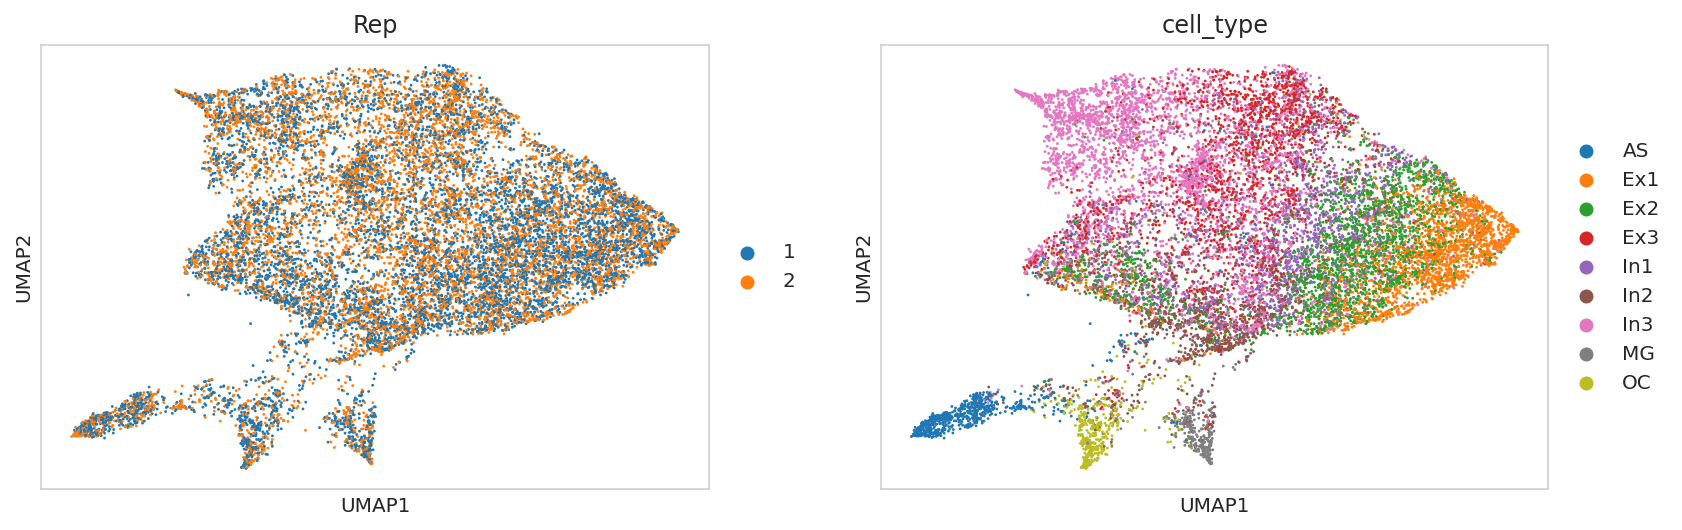

In [63]:
sc.pl.umap(scatac, color=['Rep', 'cell_type'])

### Running UMAP

In [64]:
sc.pp.neighbors(scatac, random_state=42)
sc.tl.umap(scatac, random_state=42)

         Falling back to preprocessing with `sc.pp.pca` and default params.


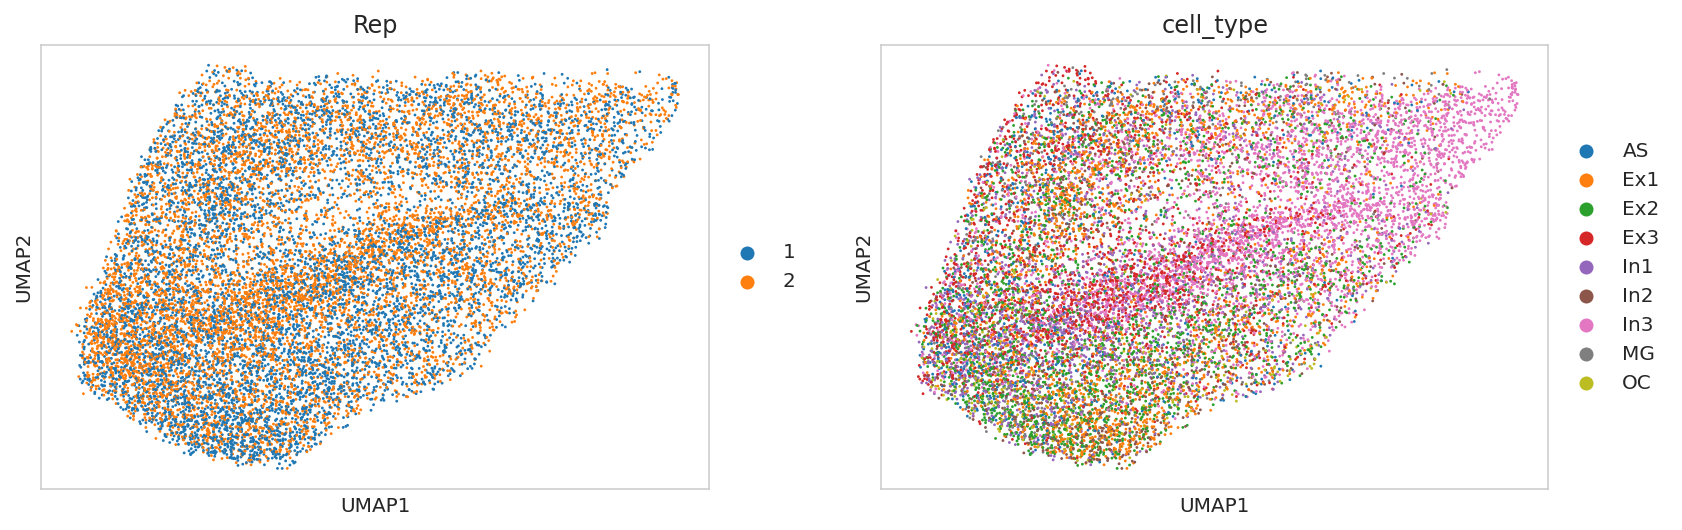

In [65]:
sc.pl.umap(scatac, color=['Rep', 'cell_type'])

---
# Save the results

### Find common paired samples

In [66]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(14883, 2693) (14883, 10155)


In [67]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 116 ms, sys: 48 ms, total: 164 ms
Wall time: 412 ms


In [68]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 264 ms, sys: 44 ms, total: 308 ms
Wall time: 626 ms
